1. Tải mã & dữ liệu

# 1) Cài thư viện gọn nhẹ

In [ ]:
!pip -q install albumentations==1.4.7 opencv-python==4.10.0.84 torchmetrics==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 34.1 MB/s eta 0:00:00


# 2) Tải DeepPCB từ GitHub (chứa ảnh + nhãn)

In [ ]:
!git clone -q https://github.com/tangsanli5201/DeepPCB.git

In [ ]:
!ls -R DeepPCB | head -n 50

DeepPCB:
evaluation
fig
LICENSE
PCBData
README.md
tools

DeepPCB/evaluation:
gt.zip
readme.txt
rrc_evaluation_funcs.py
script.py

DeepPCB/fig:
CountPCB.png
result
template.jpg
test.jpg
tools

DeepPCB/fig/result:
result_temp1.jpg
result_temp2.jpg
result_temp3.jpg
result_temp4.jpg
result_test1.jpg
result_test2.jpg
result_test3.jpg
result_test4.jpg

DeepPCB/fig/tools:
PCBAnnotationSoftware.png

DeepPCB/PCBData:
group00041
group12000
group12100
group12300
group13000
group20085
group44000
group50600
group77000
group90100
group92000
test.txt
trainval.txt

DeepPCB/PCBData/group00041:


Tạo danh sách cặp ảnh + mask (CSV)

In [ ]:
import os, cv2, glob, csv
from pathlib import Path
import numpy as np

root = Path("DeepPCB/PCBData")  # thư mục gốc dữ liệu trong repo
pairs = []

# duyệt các cặp GOLDEN/TEST theo quy ước tên ..._temp.jpg & ..._test.jpg
for test_path in glob.glob(str(root / "**/*_test.jpg"), recursive=True):
    test_path = Path(test_path)
    temp_path = test_path.with_name(test_path.name.replace("_test.jpg", "_temp.jpg"))
    if temp_path.exists():
        # tạo pseudo-mask từ |test - temp|
        img_t = cv2.imread(str(temp_path), cv2.IMREAD_GRAYSCALE)
        img_x = cv2.imread(str(test_path), cv2.IMREAD_GRAYSCALE)
        if img_t is None or img_x is None:
            continue
        h, w = img_x.shape
        # resize về cùng size nếu lệch nhỏ (DeepPCB thường đã align và cùng size)
        if img_t.shape != img_x.shape:
            img_t = cv2.resize(img_t, (w, h), interpolation=cv2.INTER_LINEAR)
        diff = cv2.absdiff(img_x, img_t)
        diff = cv2.GaussianBlur(diff, (5,5), 0)
        # ngưỡng thành mask nhị phân
        _, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # lưu mask tạm vào /content/masks/
        mask_dir = Path("masks"); mask_dir.mkdir(exist_ok=True)
        mask_path = mask_dir / (test_path.stem.replace("_test","") + "_mask.png")
        cv2.imwrite(str(mask_path), mask)

        pairs.append((str(temp_path), str(test_path), str(mask_path)))

print("Tổng số cặp:", len(pairs))

# chia 90% train / 10% val
n = len(pairs); n_tr = int(n*0.9)
train_pairs, val_pairs = pairs[:n_tr], pairs[n_tr:]

# ghi CSV
with open("train_pairs.csv","w",newline="") as f:
    w=csv.writer(f); [w.writerow(r) for r in train_pairs]
with open("val_pairs.csv","w",newline="") as f:
    w=csv.writer(f); [w.writerow(r) for r in val_pairs]

print("train_pairs.csv:", len(train_pairs), " | val_pairs.csv:", len(val_pairs))


Tổng số cặp: 1500
train_pairs.csv: 1350  | val_pairs.csv: 150


Dataset & Augmentation (6 kênh: concat [GOLDEN, TEST])

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader

class PairSegDataset(Dataset):
    def __init__(self, csv_path, size=512, aug=True):
        self.items = [tuple(line.strip().split(',')) for line in open(csv_path)]
        self.tr = A.Compose([
            A.Resize(size, size),
            A.HorizontalFlip(p=0.5 if aug else 0.0),
            A.RandomBrightnessContrast(p=0.3 if aug else 0.0),
            ToTensorV2(),
        ])

    def __len__(self): return len(self.items)

    def __getitem__(self, i):
        temp_p, test_p, mask_p = self.items[i]
        t = cv2.imread(temp_p, cv2.IMREAD_GRAYSCALE)
        x = cv2.imread(test_p, cv2.IMREAD_GRAYSCALE)
        m = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
        assert t is not None and x is not None and m is not None
        # chuẩn hóa [0,1] và stack thành 2 kênh xám → rồi lặp thành 3 kênh mỗi ảnh → 6 kênh
        t = (t.astype('float32')/255.0)[...,None]
        x = (x.astype('float32')/255.0)[...,None]
        t3 = np.repeat(t, 3, axis=2); x3 = np.repeat(x, 3, axis=2)  # (H,W,3) + (H,W,3)
        img6 = np.concatenate([t3, x3], axis=2)                    # (H,W,6)
        m = (m>0).astype('float32')
        out = self.tr(image=img6, mask=m)
        img6 = out["image"]              # <-- GIỮ NGUYÊN, KHÔNG permute nữa
        mask = out["mask"].unsqueeze(0)  # (1,H,W) là đúng

        return img6, mask

# test nhanh
ds = PairSegDataset("train_pairs.csv", size=512, aug=True)
img6, m = ds[0]
img6.shape, m.shape

(torch.Size([6, 512, 512]), torch.Size([1, 512, 512]))

Mô hình baseline (UNet 6 kênh) + Loss (BCE + Dice)

In [ ]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self,x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=6, base=32):
        super().__init__()
        self.d1 = DoubleConv(in_ch, base);   self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(base, base*2);  self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(base*2, base*4);self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(base*4, base*8);self.p4 = nn.MaxPool2d(2)
        self.b  = DoubleConv(base*8, base*16)

        self.u4 = nn.ConvTranspose2d(base*16, base*8, 2, 2); self.c4 = DoubleConv(base*16, base*8)
        self.u3 = nn.ConvTranspose2d(base*8,  base*4, 2, 2); self.c3 = DoubleConv(base*8,  base*4)
        self.u2 = nn.ConvTranspose2d(base*4,  base*2, 2, 2); self.c2 = DoubleConv(base*4,  base*2)
        self.u1 = nn.ConvTranspose2d(base*2,  base,   2, 2); self.c1 = DoubleConv(base*2,  base)
        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        d1 = self.d1(x); d2 = self.d2(self.p1(d1)); d3 = self.d3(self.p2(d2)); d4 = self.d4(self.p3(d3))
        b  = self.b(self.p4(d4))
        x = self.u4(b);  x = self.c4(torch.cat([x, d4], 1))
        x = self.u3(x);  x = self.c3(torch.cat([x, d3], 1))
        x = self.u2(x);  x = self.c2(torch.cat([x, d2], 1))
        x = self.u1(x);  x = self.c1(torch.cat([x, d1], 1))
        return self.out(x)

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6): super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum() + self.eps
        den = probs.sum() + targets.sum() + self.eps
        return 1 - num/den

# Thêm mô hình “Siamese encoder chia sẻ”

In [ ]:
# === Siamese Encoder + U-Net decoder (trọng số encoder dùng chung) ===
import torch, torch.nn as nn

class _DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class _Encoder(nn.Module):
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        self.d1 = _DoubleConv(in_ch, base);     self.p1 = nn.MaxPool2d(2)
        self.d2 = _DoubleConv(base, base*2);    self.p2 = nn.MaxPool2d(2)
        self.d3 = _DoubleConv(base*2, base*4);  self.p3 = nn.MaxPool2d(2)
        self.d4 = _DoubleConv(base*4, base*8);  self.p4 = nn.MaxPool2d(2)
        self.b  = _DoubleConv(base*8, base*16)
    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.p1(d1))
        d3 = self.d3(self.p2(d2))
        d4 = self.d4(self.p3(d3))
        b  = self.b(self.p4(d4))
        return [d1, d2, d3, d4, b]  # từ 1/2 tới 1/32

class SiameseUNetShared(nn.Module):
    """
    Nhận 2 ảnh: golden (g) và test (t) dạng (B,3,H,W).
    Tạo skip = |E_g - E_t| ở mỗi mức, rồi decode như U-Net để ra logits (B,1,H/2,W/2).
    """
    def __init__(self, in_ch=3, base=32):
        super().__init__()
        self.enc = _Encoder(in_ch, base)          # DÙNG CHUNG TRỌNG SỐ
        # decoder (dùng cộng thay vì concat cho gọn nhẹ)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, 2)
        self.dc4 = _DoubleConv(base*8, base*8)
        self.up3 = nn.ConvTranspose2d(base*8,  base*4, 2, 2)
        self.dc3 = _DoubleConv(base*4, base*4)
        self.up2 = nn.ConvTranspose2d(base*4,  base*2, 2, 2)
        self.dc2 = _DoubleConv(base*2, base*2)
        self.up1 = nn.ConvTranspose2d(base*2,  base,   2, 2)
        self.dc1 = _DoubleConv(base, base)
        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, g, t):
        g1,g2,g3,g4,gb = self.enc(g)
        t1,t2,t3,t4,tb = self.enc(t)
        d4 = torch.abs(g4 - t4); db = torch.abs(gb - tb)
        d3 = torch.abs(g3 - t3); d2 = torch.abs(g2 - t2); d1 = torch.abs(g1 - t1)

        x = self.up4(db); x = self.dc4(x + d4)
        x = self.up3(x);  x = self.dc3(x + d3)
        x = self.up2(x);  x = self.dc2(x + d2)
        x = self.up1(x);  x = self.dc1(x + d1)
        return self.out(x)    # logits (B,1,H/2,W/2). Ta sẽ upsample về kích thước gốc ở ngoài.


Train loop + EarlyStopping

In [ ]:
import math, torch
from torch.utils.data import DataLoader

def train_one_epoch(model, loader, opt, bce, dice, device):
    model.train(); total=0.
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        # x đang là (B,6,H,W) do dataset concat [GOLDEN(3), TEST(3)]
        g = x[:, :3]   # (B,3,H,W)
        t = x[:, 3:]   # (B,3,H,W)
        logits = model(g, t)
        loss = bce(logits, y) + dice(logits, y)
        loss.backward(); opt.step()
        total += loss.item()*x.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, bce, dice, device):
    model.eval(); total=0.
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        # x đang là (B,6,H,W) do dataset concat [GOLDEN(3), TEST(3)]
        g = x[:, :3]   # (B,3,H,W)
        t = x[:, 3:]   # (B,3,H,W)
        logits = model(g, t)
        loss = bce(logits, y) + dice(logits, y)
        total += loss.item()*x.size(0)
    return total/len(loader.dataset)

def fit(train_csv, val_csv, size=512, epochs=109, batch=4, lr=1e-4, patience=107, device='cuda'):
    tr = DataLoader(PairSegDataset(train_csv, size, aug=True),  batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    va = DataLoader(PairSegDataset(val_csv,   size, aug=False), batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)
    model = SiameseUNetShared(in_ch=3, base=32).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    bce, dice = nn.BCEWithLogitsLoss(), DiceLoss()

    train_losses, val_losses = [], []
    os.makedirs("artifacts/report_samples", exist_ok=True)

    best = math.inf; bad = 0
    for e in range(1, epochs+1):
        tr_loss = train_one_epoch(model, tr, opt, bce, dice, device)
        va_loss = eval_epoch(model, va, bce, dice, device)
        train_losses.append(tr_loss); val_losses.append(va_loss)
        print(f"Epoch {e}: train {tr_loss:.4f} | valid {va_loss:.4f}")

        if va_loss < best - 1e-4:
            best = va_loss; bad = 0
            torch.save(model.state_dict(), "siamese_unet_best.pth")
        # else:
        #     bad += 1
        #     if bad >= patience:
        #         print("Early stop!"); break

    np.savez("artifacts/report_samples/history.npz",
             train_losses=np.array(train_losses),
             val_losses=np.array(val_losses))
    return model, train_losses, val_losses

# chạy train nhanh:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_ = fit("train_pairs.csv", "val_pairs.csv",
        size=512, epochs=109, batch=4, lr=1e-4,
        patience=99, device=device)



Epoch 1: train 1.1513 | valid 1.0563
Epoch 2: train 0.9028 | valid 0.8856
Epoch 3: train 0.7171 | valid 0.7222
Epoch 4: train 0.5466 | valid 0.5504
Epoch 5: train 0.4090 | valid 0.4408
Epoch 6: train 0.3240 | valid 0.3622
Epoch 7: train 0.2719 | valid 0.3054
Epoch 8: train 0.2333 | valid 0.2655
Epoch 9: train 0.2122 | valid 0.2443
Epoch 10: train 0.1990 | valid 0.2504
Epoch 11: train 0.1894 | valid 0.2149
Epoch 12: train 0.1828 | valid 0.2928
Epoch 13: train 0.1773 | valid 0.2503
Epoch 14: train 0.1737 | valid 0.2774
Epoch 15: train 0.1688 | valid 0.2386
Epoch 16: train 0.1673 | valid 0.2315
Epoch 17: train 0.1642 | valid 0.2124
Epoch 18: train 0.1649 | valid 0.2588
Epoch 19: train 0.1614 | valid 0.2131
Epoch 20: train 0.1615 | valid 0.2303
Epoch 21: train 0.1585 | valid 0.2582
Epoch 22: train 0.1576 | valid 0.2491
Epoch 23: train 0.1571 | valid 0.2096
Epoch 24: train 0.1543 | valid 0.2381
Epoch 25: train 0.1527 | valid 0.2618
Epoch 26: train 0.1525 | valid 0.2826
Epoch 27: train 0.151

KeyboardInterrupt: 

In [ ]:
import os, math, numpy as np, torch
from torch.utils.data import DataLoader

def fit_append_history(train_csv, val_csv, size=512, epochs=5, batch=4, lr=1e-4,
                       device='cuda', ckpt_path="siamese_unet_best.pth"):
    # 1) Load (hoặc khởi tạo) history
    hist_path = "artifacts/report_samples/history.npz"
    os.makedirs("artifacts/report_samples", exist_ok=True)
    if os.path.exists(hist_path):
        h = np.load(hist_path)
        train_losses = list(h["train_losses"])
        val_losses   = list(h["val_losses"])
    else:
        train_losses, val_losses = [], []

    # 2) Dựng model + (tuỳ chọn) load ckpt tốt nhất hiện có để “tiếp tục”
    model = SiameseUNetShared(in_ch=3, base=32).to(device)
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded ckpt: {ckpt_path}")

    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    bce, dice = nn.BCEWithLogitsLoss(), DiceLoss()

    tr_loader = DataLoader(PairSegDataset(train_csv, size, aug=True),  batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    va_loader = DataLoader(PairSegDataset(val_csv,   size, aug=False), batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)

    # 3) Train “bù” vài epoch; SAU MỖI EPOCH đều save history để tránh mất khi dừng
    best = math.inf
    for e in range(1, epochs+1):
        tr_loss = train_one_epoch(model, tr_loader, opt, bce, dice, device)
        va_loss = eval_epoch(model, va_loader, bce, dice, device)
        train_losses.append(tr_loss); val_losses.append(va_loss)
        print(f"[append] Epoch {len(train_losses)}: train {tr_loss:.4f} | val {va_loss:.4f}")

        # cập nhật ckpt tốt nhất
        if va_loss < best - 1e-4:
            best = va_loss
            torch.save(model.state_dict(), ckpt_path)

        # lưu history ngay lập tức để tránh mất khi bị dừng
        np.savez(hist_path, train_losses=np.array(train_losses), val_losses=np.array(val_losses))

    print("✅ history saved to", hist_path)
    return train_losses, val_losses

# GỌI CHẠY: chạy 3–8 epoch là đủ để có đường cong
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_ = fit_append_history("train_pairs.csv", "val_pairs.csv",
                       size=512, epochs=5, batch=4, lr=1e-4,
                       device=device, ckpt_path="siamese_unet_best.pth")


Loaded ckpt: siamese_unet_best.pth
[append] Epoch 1: train 0.1537 | val 0.2292
[append] Epoch 2: train 0.1530 | val 0.2249
[append] Epoch 3: train 0.1510 | val 0.1952
[append] Epoch 4: train 0.1496 | val 0.2636
[append] Epoch 5: train 0.1498 | val 0.2197
✅ history saved to artifacts/report_samples/history.npz


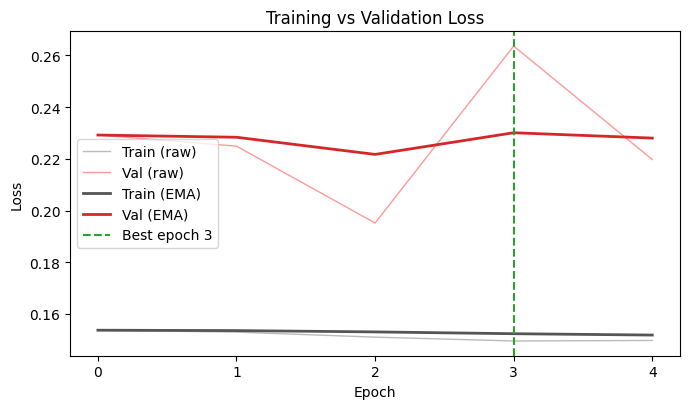

Saved: loss_curve.jpg + best_epoch.json


In [ ]:
import numpy as np, matplotlib.pyplot as plt, os, json
import matplotlib.ticker as mticker


os.makedirs("artifacts/report_samples", exist_ok=True)
hist = np.load("artifacts/report_samples/history.npz")
train_losses, val_losses = hist["train_losses"], hist["val_losses"]

# EMA smoothing nhẹ cho đẹp mắt
def ema(x, alpha=0.2):
    y = []
    for v in x: y.append(v if not y else alpha*v + (1-alpha)*y[-1])
    return np.array(y)

tr_s, va_s = ema(train_losses, 0.2), ema(val_losses, 0.2)
best_ep = int(np.argmin(val_losses)) + 1

plt.figure(figsize=(7,4.2))
plt.plot(train_losses, color="#bbbbbb", lw=1, label="Train (raw)")
plt.plot(val_losses,   color="#ff9999", lw=1, label="Val (raw)")
plt.plot(tr_s, color="#555555", lw=2, label="Train (EMA)")
plt.plot(va_s, color="#d62728", lw=2, label="Val (EMA)")
plt.axvline(best_ep, color="#2ca02c", ls="--", lw=1.5, label=f"Best epoch {best_ep}")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(loc="best"); plt.tight_layout()
plt.savefig("artifacts/report_samples/loss_curve.jpg", dpi=150);
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.show()

with open("artifacts/report_samples/best_epoch.json","w") as f:
    json.dump({"best_epoch": int(best_ep),
               "best_val_loss": float(val_losses[best_ep-1])}, f, indent=2)
print("Saved: loss_curve.jpg + best_epoch.json")


In [ ]:
import cv2, torch, numpy as np
import torch.nn.functional as F

# (tùy chọn) cache model để không load lại mỗi lần
_model_cache = {}

@torch.no_grad()
def predict_mask(temp_path, test_path, ckpt="siamese_unet_best.pth", size=512, device=None):
    """
    Trả về prob map (numpy, 0..1) của vùng sai khác giữa GOLDEN và TEST
    theo mô hình SiameseUNetShared.
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    # đọc ảnh xám
    t = cv2.imread(temp_path, cv2.IMREAD_GRAYSCALE)
    x = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
    if t is None or x is None:
        raise FileNotFoundError(f"Không đọc được ảnh: {temp_path} hoặc {test_path}")
    h, w = x.shape
    if t.shape != (h, w):
        t = cv2.resize(t, (w, h))

    # chuyển 1 kênh -> 3 kênh, chuẩn hóa [0,1]
    t3 = np.repeat((t/255.).astype('float32')[..., None], 3, axis=2)
    x3 = np.repeat((x/255.).astype('float32')[..., None], 3, axis=2)

    # resize về input size của model
    g = cv2.resize(t3, (size, size))
    s = cv2.resize(x3, (size, size))

    g_t = torch.from_numpy(g).permute(2,0,1).unsqueeze(0).to(device)
    s_t = torch.from_numpy(s).permute(2,0,1).unsqueeze(0).to(device)

    # lấy/khởi tạo model đúng kiến trúc Siamese
    if ckpt not in _model_cache:
        m = SiameseUNetShared(in_ch=3, base=32).to(device)
        m.load_state_dict(torch.load(ckpt, map_location=device))
        m.eval()
        _model_cache[ckpt] = m
    m = _model_cache[ckpt]

    # forward
    logits = m(g_t, s_t)
    prob = torch.sigmoid(
        F.interpolate(logits, size=(h, w), mode="bilinear", align_corners=False)
    )[0,0].cpu().numpy()

    return prob


In [ ]:
prob = predict_mask(t_path, x_path, ckpt="siamese_unet_best.pth",
                    size=512, device=('cuda' if torch.cuda.is_available() else 'cpu'))


In [ ]:
import cv2, numpy as np, pandas as pd, os, torch
from pathlib import Path

def dice_iou(pred255, gt255):
    p = (pred255>0).astype(np.uint8); g = (gt255>0).astype(np.uint8)
    inter = (p & g).sum(); union = (p | g).sum()
    dice = (2*inter) / (p.sum() + g.sum() + 1e-6)
    iou  = inter / (union + 1e-6)
    return float(dice), float(iou)

rows=[]
for i, line in enumerate(open("val_pairs.csv")):
    t_path, x_path, m_path = line.strip().split(',')
    prob = predict_mask(t_path, x_path, ckpt="siamese_unet_best.pth",
                        size=512, device=('cuda' if torch.cuda.is_available() else 'cpu'))
    pred = (prob>0.5).astype(np.uint8)*255
    gt   = cv2.imread(m_path, 0)
    d, j = dice_iou(pred, gt)
    rows.append({"id":i, "dice":d, "miou":j, "template":t_path, "test":x_path, "mask":m_path})

df = pd.DataFrame(rows)
os.makedirs("artifacts/report_samples", exist_ok=True)
df.to_csv("artifacts/report_samples/metrics_val.csv", index=False)
print("Mean Dice: %.2f%% | Mean mIoU: %.2f%%" % (df.dice.mean()*100, df.miou.mean()*100))
df.head()


Mean Dice: 80.59% | Mean mIoU: 69.42%


,id,dice,miou,template,test,mask
0,0,0.809386,0.679806,DeepPCB/PCBData/group00041/00041/00041119_temp...,DeepPCB/PCBData/group00041/00041/00041119_test...,masks/00041119_mask.png
1,1,0.837166,0.719935,DeepPCB/PCBData/group00041/00041/00041117_temp...,DeepPCB/PCBData/group00041/00041/00041117_test...,masks/00041117_mask.png
2,2,0.845415,0.732223,DeepPCB/PCBData/group00041/00041/00041107_temp...,DeepPCB/PCBData/group00041/00041/00041107_test...,masks/00041107_mask.png
3,3,0.811851,0.683290,DeepPCB/PCBData/group00041/00041/00041001_temp...,DeepPCB/PCBData/group00041/00041/00041001_test...,masks/00041001_mask.png
4,4,0.789273,0.651899,DeepPCB/PCBData/group00041/00041/00041115_temp...,DeepPCB/PCBData/group00041/00041/00041115_test...,masks/00041115_mask.png


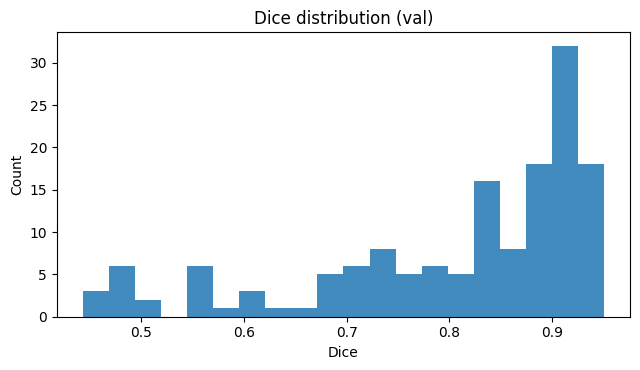

/tmp/ipython-input-5436827.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["dice"], df["miou"]], labels=["Dice","mIoU"])


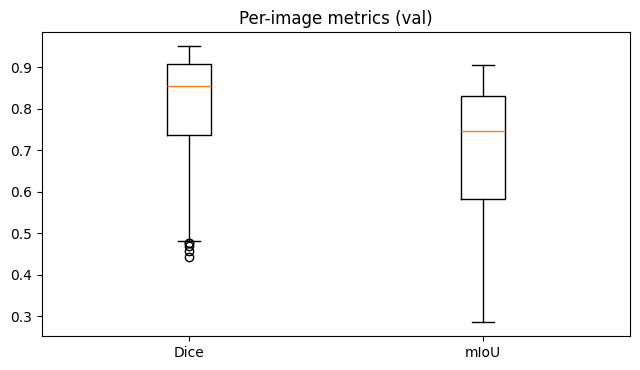

Saved: hist_dice.jpg, box_metrics.jpg


In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("artifacts/report_samples/metrics_val.csv")

plt.figure(figsize=(6.5,3.8))
plt.hist(df["dice"], bins=20, alpha=0.85)
plt.xlabel("Dice"); plt.ylabel("Count"); plt.title("Dice distribution (val)")
plt.tight_layout(); plt.savefig("artifacts/report_samples/hist_dice.jpg", dpi=150); plt.show()

plt.figure(figsize=(6.5,3.8))
plt.boxplot([df["dice"], df["miou"]], labels=["Dice","mIoU"])
plt.title("Per-image metrics (val)"); plt.tight_layout()
plt.savefig("artifacts/report_samples/box_metrics.jpg", dpi=150); plt.show()
print("Saved: hist_dice.jpg, box_metrics.jpg")


/tmp/ipython-input-961373730.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr  = np.trapz(y=precision[::-1], x=recall[::-1])
/tmp/ipython-input-961373730.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_roc = np.trapz(y=tpr, x=fpr)


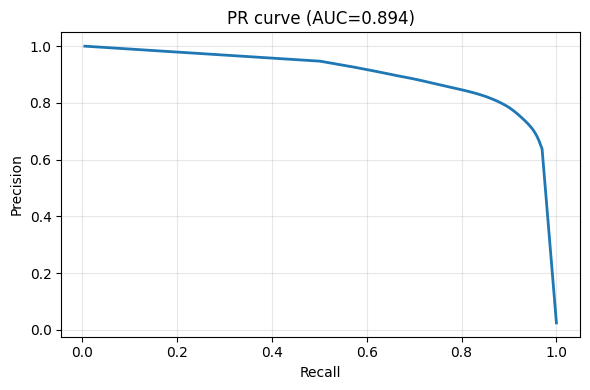

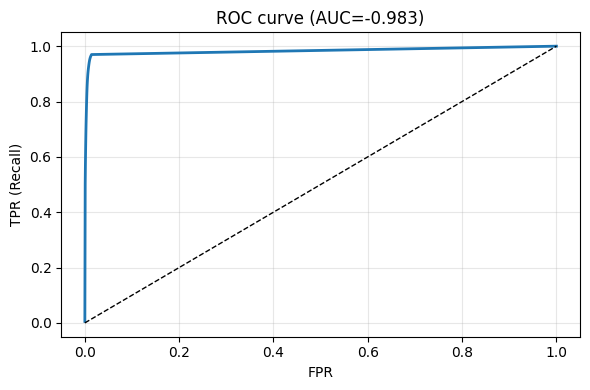

Saved: pr_curve.jpg (AUC=0.894), roc_curve.jpg (AUC=-0.983)


In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt, torch

ths = np.linspace(0, 1, 101)
TP = np.zeros_like(ths); FP = np.zeros_like(ths)
FN = np.zeros_like(ths); TN = np.zeros_like(ths)

for line in open("val_pairs.csv"):
    t_path, x_path, m_path = line.strip().split(',')
    prob = predict_mask(t_path, x_path, ckpt="siamese_unet_best.pth",
                        size=512, device=('cuda' if torch.cuda.is_available() else 'cpu'))
    gt = (cv2.imread(m_path, 0) > 0).astype(np.uint8)

    P = gt.sum(); N = gt.size - P
    for k, thr in enumerate(ths):
        p = (prob >= thr).astype(np.uint8)
        tp = np.logical_and(p==1, gt==1).sum()
        fp = np.logical_and(p==1, gt==0).sum()
        fn = np.logical_and(p==0, gt==1).sum()
        tn = np.logical_and(p==0, gt==0).sum()
        TP[k]+=tp; FP[k]+=fp; FN[k]+=fn; TN[k]+=tn

precision = TP / np.maximum(TP+FP, 1e-9)
recall    = TP / np.maximum(TP+FN, 1e-9)
tpr       = recall
fpr       = FP / np.maximum(FP+TN, 1e-9)

# AUC (simple trapezoid)
auc_pr  = np.trapz(y=precision[::-1], x=recall[::-1])
auc_roc = np.trapz(y=tpr, x=fpr)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR curve (AUC={auc_pr:.3f})"); plt.grid(alpha=.3)
plt.tight_layout(); plt.savefig("artifacts/report_samples/pr_curve.jpg", dpi=150); plt.show()

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR (Recall)")
plt.title(f"ROC curve (AUC={auc_roc:.3f})"); plt.grid(alpha=.3)
plt.tight_layout(); plt.savefig("artifacts/report_samples/roc_curve.jpg", dpi=150); plt.show()

print(f"Saved: pr_curve.jpg (AUC={auc_pr:.3f}), roc_curve.jpg (AUC={auc_roc:.3f})")


In [ ]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, shutil, torch
from pathlib import Path

outdir = Path("artifacts/report_samples"); (outdir/"cases").mkdir(parents=True, exist_ok=True)
for i, line in enumerate(open("val_pairs.csv")):
    if i>=20: break
    t_path, x_path, m_path = line.strip().split(',')
    gt = cv2.imread(m_path,0)
    prob = predict_mask(t_path, x_path, ckpt="siamese_unet_best.pth",
                        size=512, device=('cuda' if torch.cuda.is_available() else 'cpu'))
    pred = (prob>0.5).astype(np.uint8)*255
    gold = cv2.imread(t_path,0); test = cv2.imread(x_path,0)
    overlay = cv2.applyColorMap(pred, cv2.COLORMAP_JET)
    blend = cv2.addWeighted(cv2.cvtColor(test,cv2.COLOR_GRAY2BGR),0.7,overlay,0.3,0)
    fig, axs = plt.subplots(1,4, figsize=(14,4))
    for ax,img,title in zip(axs,[gold,test,gt,blend[...,::-1]],["Golden","Test","GT Mask","Pred Overlay"]):
        ax.imshow(img, cmap='gray' if title!="Pred Overlay" else None); ax.set_title(title); ax.axis('off')
    fig.tight_layout(); fig.savefig(outdir/"cases"/f"case_{i:02d}.jpg", dpi=150); plt.close(fig)

zip_path = shutil.make_archive("SiameseUNet_Report", "zip", "artifacts/report_samples")
print("ZIP ready:", zip_path)


ZIP ready: /content/SiameseUNet_Report.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseUNetShared(in_ch=3, base=32).to(device)
model.load_state_dict(torch.load("siamese_unet_best.pth", map_location=device))
model.eval()
print("✅ Loaded best SiameseUNetShared checkpoint!")

✅ Loaded best SiameseUNetShared checkpoint!


Test & trực quan hoá kết quả

In [ ]:
import torch, cv2, numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt

@torch.no_grad()
def predict_mask(temp_path, test_path, ckpt="siamese_unet_best.pth", size=512, device='cuda'):
    # load ảnh grayscale
    t = cv2.imread(temp_path, cv2.IMREAD_GRAYSCALE)
    x = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
    h, w = x.shape
    if t.shape != (h, w):
        t = cv2.resize(t, (w, h))

    # chuẩn hoá về [0,1], thành 3 kênh
    t3 = np.repeat((t / 255.).astype('float32')[..., None], 3, axis=2)
    x3 = np.repeat((x / 255.).astype('float32')[..., None], 3, axis=2)

    # resize cho mô hình
    g = cv2.resize(t3, (size, size))
    s = cv2.resize(x3, (size, size))

    g_t = torch.from_numpy(g).permute(2, 0, 1).unsqueeze(0).to(device)
    s_t = torch.from_numpy(s).permute(2, 0, 1).unsqueeze(0).to(device)

    # tạo đúng model SiameseUNetShared
    m = SiameseUNetShared(in_ch=3, base=32).to(device)
    m.load_state_dict(torch.load(ckpt, map_location=device))
    m.eval()

    # forward song song golden/test
    logits = m(g_t, s_t)
    prob = torch.sigmoid(F.interpolate(
        logits, size=(h, w), mode='bilinear', align_corners=False
    ))[0, 0].cpu().numpy()

    return prob


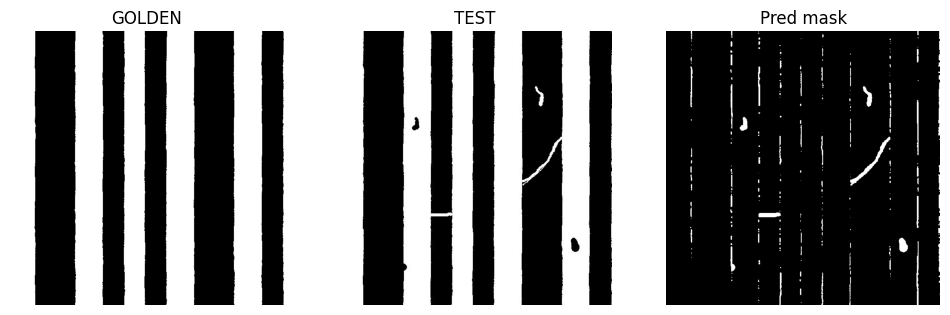

In [ ]:
sample_test = pairs[-1][1]
sample_temp = pairs[-1][0]
prob = predict_mask(sample_temp, sample_test, device=device)
pred = (prob > 0.5).astype('uint8') * 255

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("GOLDEN"); plt.imshow(cv2.imread(sample_temp,0), cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("TEST");   plt.imshow(cv2.imread(sample_test,0), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Pred mask"); plt.imshow(pred, cmap='gray'); plt.axis('off')
plt.show()


Tạo hàm predict_prob()

In [ ]:
import torch, cv2, numpy as np
import torch.nn.functional as F

@torch.no_grad()
def predict_prob(temp_path, test_path, ckpt="siamese_unet_best.pth", size=512, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    t = cv2.imread(temp_path, 0)
    x = cv2.imread(test_path, 0)
    h, w = x.shape
    if t.shape != (h, w):
        t = cv2.resize(t, (w, h))
    t3 = np.repeat((t / 255.).astype('float32')[..., None], 3, axis=2)
    x3 = np.repeat((x / 255.).astype('float32')[..., None], 3, axis=2)
    img6 = np.concatenate([t3, x3], axis=2)
    ten = torch.from_numpy(cv2.resize(img6, (size, size))).permute(2, 0, 1).unsqueeze(0).to(device)

    m = SiameseUNetShared(in_ch=3, base=32).to(device)
    m.load_state_dict(torch.load(ckpt, map_location=device))
    m.eval()
    g, t = ten[:, :3], ten[:, 3:]
    logits = m(g, t)
    prob = torch.sigmoid(F.interpolate(
        logits, size=(h, w), mode="bilinear", align_corners=False
    ))[0, 0].cpu().numpy()
    return prob


Tính số liệu (Dice, mIoU) trên tập overlay

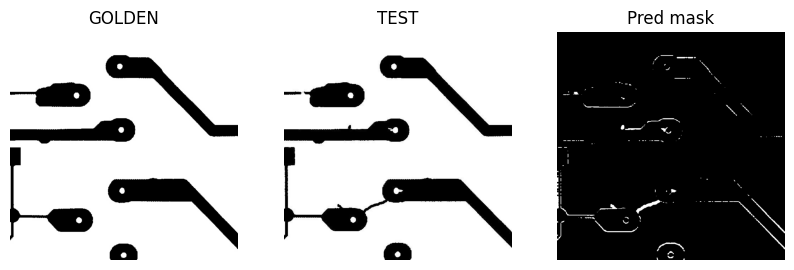

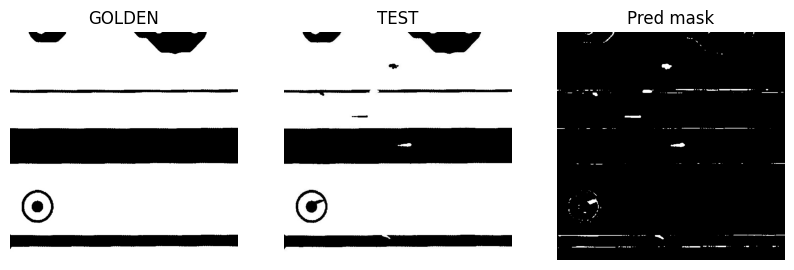

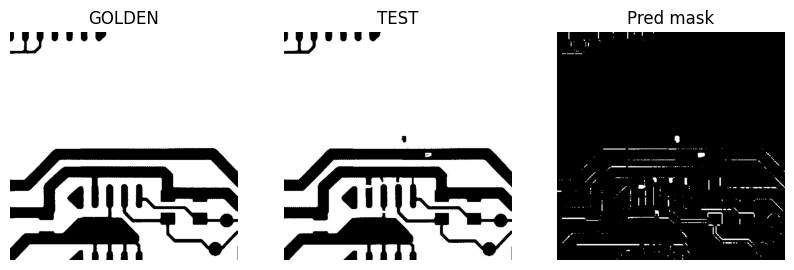

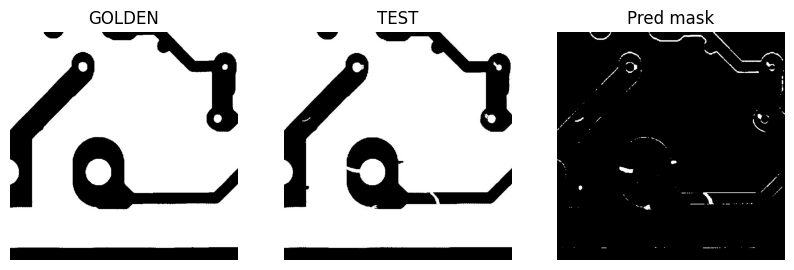

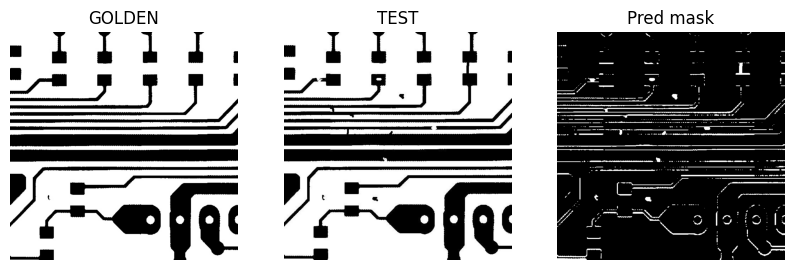

Mean Dice: 81.26% | Mean mIoU: 68.44%


In [ ]:
import pandas as pd, matplotlib.pyplot as plt, os
os.makedirs("artifacts/samples_siamese", exist_ok=True)

def dice_iou(pred255, gt255):
    p = (pred255>0).astype(np.uint8); g = (gt255>0).astype(np.uint8)
    inter = (p & g).sum()
    union = (p | g).sum()
    dice = (2*inter)/(p.sum()+g.sum()+1e-6)
    iou  = inter/(union+1e-6)
    return dice, iou

rows=[]
for i,line in enumerate(open("val_pairs.csv")):
    if i>=5: break
    tp, ip, mp = line.strip().split(',')
    prob = predict_prob(tp, ip, ckpt="siamese_unet_best.pth", size=512, device=device)
    pred = (prob>0.5).astype(np.uint8)*255
    gt   = cv2.imread(mp,0)
    d, j = dice_iou(pred, gt)
    x = cv2.imread(ip,0)
    heat = cv2.applyColorMap(pred, cv2.COLORMAP_JET)
    over = cv2.addWeighted(cv2.cvtColor(x,cv2.COLOR_GRAY2BGR),0.7,heat,0.3,0)
    outp = f"artifacts/samples_siamese/overlay_{i}.jpg"
    cv2.imwrite(outp, over)
    rows.append({"id":i,"dice":d,"miou":j,"overlay":outp})
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.title("GOLDEN"); plt.imshow(cv2.imread(tp,0), cmap='gray'); plt.axis('off')
    plt.subplot(1,3,2); plt.title("TEST");   plt.imshow(x, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,3); plt.title("Pred mask"); plt.imshow(pred, cmap='gray'); plt.axis('off')
    plt.show()

df = pd.DataFrame(rows)
print("Mean Dice: %.2f%% | Mean mIoU: %.2f%%"%(df.dice.mean()*100, df.miou.mean()*100))


In [ ]:
import os, cv2, torch, numpy as np, matplotlib.pyplot as plt, pandas as pd
os.makedirs("artifacts/report_samples", exist_ok=True)

# đọc lại model tốt nhất
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseUNetShared(in_ch=3, base=32).to(device)
model.load_state_dict(torch.load("siamese_unet_best.pth", map_location=device))
model.eval()

rows = []
for i, line in enumerate(open("val_pairs.csv")):
    if i >= 20: break   # lấy 20 mẫu minh họa
    t_path, x_path, m_path = line.strip().split(',')
    gt = cv2.imread(m_path, 0)
    prob = predict_mask(t_path, x_path, ckpt="siamese_unet_best.pth", size=512, device=device)
    pred = (prob > 0.5).astype('uint8') * 255
    dice = (2 * np.sum((pred>0)&(gt>0))) / (np.sum(pred>0)+np.sum(gt>0)+1e-6)
    iou = np.sum((pred>0)&(gt>0)) / (np.sum((pred>0)|(gt>0))+1e-6)
    rows.append(dict(id=i, dice=dice, iou=iou))

    gold = cv2.imread(t_path, 0)
    test = cv2.imread(x_path, 0)
    overlay = cv2.applyColorMap(pred, cv2.COLORMAP_JET)
    blend = cv2.addWeighted(cv2.cvtColor(test, cv2.COLOR_GRAY2BGR), 0.7, overlay, 0.3, 0)
    fig, axs = plt.subplots(1,4, figsize=(14,4))
    axs[0].imshow(gold, cmap='gray'); axs[0].set_title("Golden"); axs[0].axis('off')
    axs[1].imshow(test, cmap='gray'); axs[1].set_title("Test"); axs[1].axis('off')
    axs[2].imshow(gt, cmap='gray'); axs[2].set_title("GT Mask"); axs[2].axis('off')
    axs[3].imshow(blend[...,::-1]); axs[3].set_title("Pred Overlay"); axs[3].axis('off')
    fig.tight_layout()
    fig.savefig(f"artifacts/report_samples/case_{i:02d}.jpg", dpi=150)
    plt.close(fig)

pd.DataFrame(rows).to_csv("artifacts/report_samples/metrics.csv", index=False)
print("✅ Saved all visual samples and metrics to artifacts/report_samples/")


✅ Saved all visual samples and metrics to artifacts/report_samples/


In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')
shutil.move("SiameseUNet_Report.zip", "/content/drive/MyDrive/SiameseUNet_Report.zip")
print("✅ Uploaded to Drive: MyDrive/SiameseUNet_Report.zip")


Mounted at /content/drive
✅ Uploaded to Drive: MyDrive/SiameseUNet_Report.zip
